In [1]:
import argparse
import json
import os
import glob

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import librosa

from Separator import *
from Dataset import *
from Layers import *
from Models import *
from Losses import *
from Metrics import *
from Utils import *
from PyFire import Trainer
from VisualizationsAndDemonstrations import *
import scipy.io.wavfile as wavfile

import wave
import numpy as np
import datetime

# wav 파일을 읽어서 numpy 배열로 반환
def read_wav(filename):
    with wave.open(filename, 'rb') as w:
        n = w.getnframes()
        data = w.readframes(n)
        dtype = np.int16 if w.getsampwidth() == 2 else np.int8
        return np.frombuffer(data, dtype=dtype)

# numpy 배열을 wav 파일로 저장
def save_wav(filename, data, params):
    with wave.open(filename, 'wb') as w:
        w.setparams(params)
        w.writeframes(data.tobytes())




#Data Mixing

In [7]:

year = datetime.datetime.now().year
month = datetime.datetime.now().month
day = datetime.datetime.now().day

date = str(year) + str(month) + str(day)

bird_path = 'D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/BioacousticData/Bird/clean_bird'
noise_path = 'D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/BioacousticData/Bird/back_noise'

bird_datas = [f for f in os.listdir(bird_path) if f.endswith('.wav')]
noise_datas = [f for f in os.listdir(noise_path) if f.endswith('.wav')]

file1_name = random.sample(bird_datas,1)
file2_name = random.sample(noise_datas,1)

file1_path = os.path.join(bird_path, file1_name[-1])
file2_path = os.path.join(noise_path, file2_name[-1])
result_path = "D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/Assets/Bird/result"

# 두 소리 파일 읽기
data1 = read_wav(file1_path)
data2 = read_wav(file2_path)

# 두 소리 데이터의 길이가 다를 경우를 대비하여 짧은 쪽의 길이에 맞춰줌
min_len = min(len(data1), len(data2))
data1, data2 = data1[:min_len], data2[:min_len]

# 두 소리 데이터를 합성
mixed_data = data1 + data2

# 클리핑: -32768과 32767 사이의 값으로 제한
mixed_data = np.clip(mixed_data, -32768, 32767).astype(np.int16)

# 합성한 데이터를 새로운 wav 파일로 저장
with wave.open(file1_path, 'rb') as w:
    params = w.getparams()

file1_name = file1_name[-1].split('.')[0]
file2_name = file2_name[-1].split('.')[0]

try:
    os.mkdir(result_path)
except :
    pass
    
mixed_output_path = os.path.join(result_path, f'{date}__{file1_name}__{file2_name}_mixed_output.wav')
save_wav(mixed_output_path, mixed_data, params)

In [8]:
data = mixed_output_path

#1.4.7_379.wav
# file_name = "1.1.1_103.wav"
# data = "D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/BioacousticData/Bird/Bird/" + file_name

#noise
# data = "D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/BioacousticData/Bird/Noise/22050_Noise_12445.wav"
#신버전
# separator_path = "D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/Bird/Separator/Models/saver_epoch68.pt"
#구버전
separator_path = "D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/Bird/Classifier/Models/1nllloss_accuracy_.pt"

root = 'Bird/'
if root[-1] != r'/':
    root += r'/'

with open(root + 'config.json') as f:
    config = f.read()
config = json.loads(config)
 
global separator_model_config
separator_model_config = config['separator_model_params']

print(data)
data_name = data.split(".")[0]
data_name = data_name.split("/")[-1]
model_name = separator_path.split(".")[0]
model_name = model_name.split("/")[-1]

data, _ = librosa.load(data, sr=22050, duration=0.5)
data = torch.Tensor(data).reshape(1,11025)
print(data.size())
separator = RepUNet(**separator_model_config)

y = separator(data)
print(y)
print(data_name)

D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/Assets/Bird/result\230804__128909-11_6610__26_12627_13018_mixed_output.wav
torch.Size([1, 11025])
tensor([[[-0.0092, -0.0056, -0.0053,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0665, -0.0756, -0.0779,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<CatBackward0>)
result\230804__128909-11_6610__26_12627_13018_mixed_output


c:\Users\Munbong_Choi\anaconda3\envs\cock_tail\lib\site-packages\torch\functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:804.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
d:\MILAB\Experiment\animal_sound_classification\cocktail-party-problem\Layers.py:96: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:980.)
  x = torch.istft(S, n_fft=self.kernel_size, hop_length=self.stride, window=self.window).unsqueeze(dim=1)


In [9]:
data_name = data_name.split('\\')[-1]
data_np = y.detach().numpy()

data_1 = data_np[:, 0, :].reshape(11025)
data_2 = data_np[:, 1, :].reshape(11025)

sample_rate = 22050
file_name_1 = f"D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/Assets/Bird/{date}_{model_name}_{data_name}_separated_1.wav"
file_name_2 = f"D:/MILAB/Experiment/animal_sound_classification/cocktail-party-problem/Assets/Bird/{date}_{model_name}_{data_name}_separated_2.wav"

wavfile.write(file_name_1, sample_rate, data_1)
wavfile.write(file_name_2, sample_rate, data_2)


TypeError: return arrays must be of ArrayType

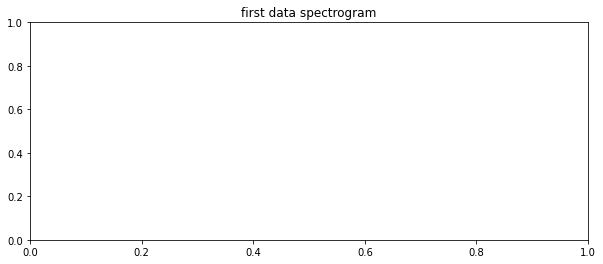

In [12]:
data_1 = np.array(data_1[0])
plt.figure(figsize=(10, 4))
plt.title("first data spectrogram")
array = librosa.display.specshow(librosa.amplitude_to_db(np.abs(data_1)), sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

TypeError: return arrays must be of ArrayType

c:\Users\Munbong_Choi\anaconda3\envs\cock_tail\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Munbong_Choi\anaconda3\envs\cock_tail\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Munbong_Choi\anaconda3\envs\cock_tail\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51704 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Munbong_Choi\anaconda3\envs\cock_tail\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Munbong_Choi\anaconda3\envs\cock_tail\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50501 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Munbon

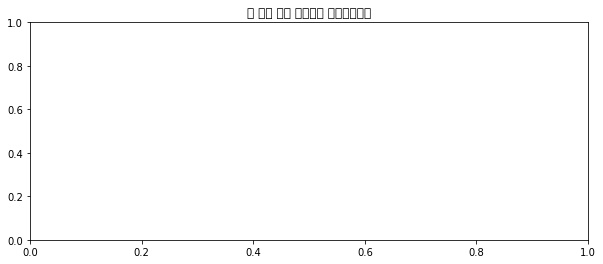

In [24]:
data_2 = np.array(data_2)
plt.figure(figsize=(10, 4))
plt.title("두 번째 음악 데이터의 스펙트로그램")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(data_2[0])), sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
path = "c:/Users/Munbong_Choi/Downloads/clean_bird/wavfiles/11713-1.wav"
data, sr = librosa.load(path)
print(sr)

#noise sr = 22050